<a href="https://colab.research.google.com/github/unjike/Modeling-and-Simulation-of-Advanced-Manufacturing-Processes/blob/main/Genetic_Algorithm_for_Material_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## Ursan Tchouteng Njike
## MS C289
## Project 7

## Importing usefull libraries
import numpy as np
import matplotlib.pyplot as plt
 
##initializing constants
k_1 = 80*10**9 # Pa                       <---           Phase 1 bulk modulus
mu_1 = 30*10**9 # Pa                      <---           Phase 1 shear modulus
sigma_1 = 1.0*10**7 # S/m                 <---           Phase 1 electrical conductivity
Kappa_1 = 4.3 # W/m-K                         <---           Phase 1 thermal conductivity
k_D = 111*10**9 # Pa                      <---           Desired Effective Bulk Modulus
mu_D = 47*10**9 # Pa                      <---           Desired Effective Shear Modulus
sigma_D = 2.1*10**7 # S/m                 <---           Desired Effective Electrical Conductivity
Kappa_D = 6.2 # W/m-K                         <---           Desired Effective Thermal Conductivity
TOL_k = 0.5 #                             <---           Bulk Modulus Tolerance
TOL_mu = 0.5 #                            <---           Shear Modulus Tolerance
TOL_sigma = 0.8 #                         <---           Electrical Tolerance
TOL_Kappa = 0.5 #                             <---           Thermal Tolerance
w = 0.8 #                                 <---           Concentration tensor weights
w_1 = 1 #                                 <---           Material property matching cost function weights


# Genetic Algorithm for Material Optimization
# Initializing genetic algorithm parameters
children = 10 #                           <---           number of children
parent = 10 #                             <---           number of parents
S = 200 #                                 <---           number of genes
G = 5000 #                                <---           total generation

W_1 = 1/3 #                               <---           cost function weight
W_2 = 1/3 #                               <---           cost function weight
W_3 = 1/3 #                               <---           cost function weight

def PI_function(k_2, mu_2, sigma_2, Kappa_2, v_2):
  #evaluating k_str, mu_str, sigma_str, K_str
  v_1 = 1-v_2
  k_strpls = k_2 + (1 - v_2)/(1/(k_1 - k_2) + 3*v_2/(3*k_2 + 4*mu_2))
  k_strmns = k_1 + v_2/(1/(k_2 - k_1) + 3*(1 - v_2)/(3*k_1 + 4*mu_1))
  k_str = (k_strpls + k_strmns)/2

  mu_strpls = mu_2 + (1 - v_2)/(1/(mu_1 - mu_2) + 6*v_2*(k_2 + 2*mu_2)/(5*mu_2*(3*k_2 + 4*mu_2)))
  mu_strmns = mu_1 + v_2/(1/(mu_2 - mu_1) + 6*(1-v_2)*(k_1 + 2*mu_1)/(5*mu_1*(3*k_1 + 4*mu_1)))
  mu_str = (mu_strpls + mu_strmns)/2

  sigma_strpls = sigma_2 + (1 - v_2)/(1/(sigma_1 - sigma_2) + v_2/(3*sigma_2))
  sigma_strmns = sigma_1 + v_2/(1/(sigma_2 - sigma_1) + (1-v_2)/(3*sigma_1))
  sigma_str = (sigma_strpls + sigma_strmns)/2

  Kappa_strpls = Kappa_2 + (1 - v_2)/(1/(Kappa_1 - Kappa_2) + v_2/(3*Kappa_2))
  Kappa_strmns = Kappa_1 + v_2/(1/(Kappa_2 - Kappa_1) + (1-v_2)/(3*Kappa_1))
  Kappa_str = (Kappa_strpls + Kappa_strmns)/2

  # evaluating C_sigma_k2, C_sigma_k1, C_sigma_mu2, C_sigma_mu1 for mechanical properties
  C_sigma_k2 = k_2*(k_str-k_1)/(v_2*k_str*(k_2-k_1))
  C_sigma_mu2 = mu_2*(mu_str-mu_1)/(v_2*mu_str*(mu_2-mu_1))

  C_sigma_k1 = (1 - v_2*C_sigma_k2**2)/v_1
  C_sigma_mu1 = (1 - v_2*C_sigma_mu2**2)/v_1


  # evaluating C_j1C_e1 and C_j1C_e1 for electrical properties
  C_j1C_e1 = sigma_1 * ((sigma_2 - sigma_str)/((1-v_2)*(sigma_2 - sigma_1)))**2 / sigma_str
  C_j2C_e2 = sigma_2 * ((sigma_str - sigma_1)/(v_2*(sigma_2 - sigma_1)))**2 / sigma_str

  # evaluating C_q1 and C_q2 for thermal properties
  C_theta2 = (Kappa_str - Kappa_1)/(v_2*(Kappa_2 - Kappa_1)) 
  C_theta1 = (1 - v_2*C_theta2)/(1 - v_2)
  C_q2 = Kappa_2*C_theta2/Kappa_str
  C_q1 = (1 - v_2*C_q2)/(1 - v_2)

  # running the numerical simulation for the mechical properties
  pi_mechanical = w_1*((k_D-k_str)/k_D)**2 + w_1*((mu_D-mu_str)/mu_D)**2 + int(C_sigma_k2 > TOL_k)*w*((C_sigma_k2 - TOL_k)/TOL_k)**2 + int(C_sigma_mu2 > TOL_mu)*w*((C_sigma_mu2 - TOL_mu)/TOL_mu)**2 + int(C_sigma_k1 > TOL_k)*w*((C_sigma_k1 - TOL_k)/TOL_k)**2 + int(C_sigma_mu1 > TOL_mu)*w*((C_sigma_mu1 - TOL_mu)/TOL_mu)**2

  # running the numerical simulation for the electrical properties
  pi_electrical = w_1*((sigma_D-sigma_str)/sigma_D)**2 + int(C_j1C_e1 > TOL_sigma)*w*((C_j1C_e1 - TOL_sigma)/TOL_sigma)**2 + int(C_j2C_e2 > TOL_sigma)*w*((C_j2C_e2 - TOL_sigma)/TOL_sigma)**2 

  # running the numerical simulation for the thermal properties
  pi_thermal = w_1*((Kappa_D - Kappa_str)/Kappa_D)**2 + int(C_q1 > TOL_sigma)*w*((C_q1 - TOL_sigma)/TOL_sigma)**2 + int(C_q2 > TOL_sigma)*w*((C_q1 - TOL_sigma)/TOL_sigma)**2 

  # sim_res = [trnsTempSim(21, Lambda[i,0],Lambda[i,1]) for i in range(S)]

  # evaluating the cost of each member of the population
  new_pi = W_1*pi_mechanical + W_2*pi_electrical + W_3*pi_thermal

  return new_pi

---------------------generation 1 ---------------------
PI_min:  47.09556190447112
PI_min:  46.83546588052176


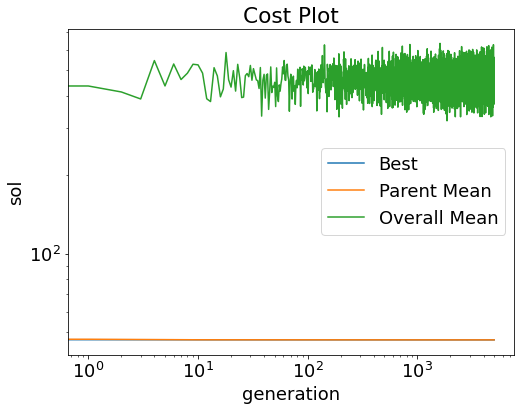

In [2]:
# random number genration
rng = np.random.default_rng()

# generating k array of size S of values between 
k_2 = k_1*rng.random((S,1)) + 100*k_1

# generating mu array of size S of values between 
mu_2 = mu_1*rng.random((S,1)) + 100*mu_1

# generating sigma array of size S of values between 
sigma_2 = sigma_1*rng.random((S,1)) + 100*sigma_1

# generating K array of size S of values between 
Kappa_2 = Kappa_1*rng.random((S,1)) + 100*Kappa_1

# generating v array of size S of values between 
v_2 = rng.random((S,1))
v_1 = 1-v_2                         # ######### # <----  Double check this value

# organizing the tunable parameter generated for the genetic algorithm
Lambda = np.hstack([k_2, mu_2, sigma_2, Kappa_2, v_2])

#evaluating k_str, mu_str, sigma_str, K_str
k_strpls = k_2 + (1 - v_2)/(1/(k_1 - k_2) + 3*v_2/(3*k_2 + 4*mu_2))
k_strmns = k_1 + v_2/(1/(k_2 - k_1) + 3*(1 - v_2)/(3*k_1 + 4*mu_1))
k_str = (k_strpls + k_strmns)/2

mu_strpls = mu_2 + (1 - v_2)/(1/(mu_1 - mu_2) + 6*v_2*(k_2 + 2*mu_2)/(5*mu_2*(3*k_2 + 4*mu_2)))
mu_strmns = mu_1 + v_2/(1/(mu_2 - mu_1) + 6*(1-v_2)*(k_1 + 2*mu_1)/(5*mu_1*(3*k_1 + 4*mu_1)))
mu_str = (mu_strpls + mu_strmns)/2

sigma_strpls = sigma_2 + (1 - v_2)/(1/(sigma_1 - sigma_2) + v_2/(3*sigma_2))
sigma_strmns = sigma_1 + v_2/(1/(sigma_2 - sigma_1) + (1-v_2)/(3*sigma_1))
sigma_str = (sigma_strpls + sigma_strmns)/2

Kappa_strpls = Kappa_2 + (1 - v_2)/(1/(Kappa_1 - Kappa_2) + v_2/(3*Kappa_2))
Kappa_strmns = Kappa_1 + v_2/(1/(Kappa_2 - Kappa_1) + (1-v_2)/(3*Kappa_1))
Kappa_str = (Kappa_strpls + Kappa_strmns)/2

# evaluating C_sigma_k2, C_sigma_k1, C_sigma_mu2, C_sigma_mu1 for mechanical properties
C_sigma_k2 = k_2*(k_str-k_1)/(v_2*k_str*(k_2-k_1))
C_sigma_mu2 = mu_2*(mu_str-mu_1)/(v_2*mu_str*(mu_2-mu_1))

C_sigma_k1 = (1 - v_2*C_sigma_k2**2)/v_1
C_sigma_mu1 = (1 - v_2*C_sigma_mu2**2)/v_1


# evaluating C_j1C_e1 and C_j1C_e1 for electrical properties
C_j1C_e1 = sigma_1 * ((sigma_2 - sigma_str)/((1-v_2)*(sigma_2 - sigma_1)))**2 / sigma_str
C_j2C_e2 = sigma_2 * ((sigma_str - sigma_1)/(v_2*(sigma_2 - sigma_1)))**2 / sigma_str

# evaluating C_q1 and C_q2 for thermal properties
C_theta2 = (Kappa_str - Kappa_1)/(v_2*(Kappa_2 - Kappa_1)) 
C_theta1 = (1 - v_2*C_theta2)/(1 - v_2)
C_q2 = Kappa_2*C_theta2/Kappa_str
C_q1 = (1 - v_2*C_q2)/(1 - v_2)

# running the numerical simulation for the mechical properties
pi_mechanical = np.array([w_1*((k_D-k_str[i])/k_D)**2 + w_1*((mu_D-mu_str[i])/mu_D)**2 + int(C_sigma_k2[i] > TOL_k)*w*((C_sigma_k2[i] - TOL_k)/TOL_k)**2 + int(C_sigma_mu2[i] > TOL_mu)*w*((C_sigma_mu2[i] - TOL_mu)/TOL_mu)**2 + int(C_sigma_k1[i] > TOL_k)*w*((C_sigma_k1[i] - TOL_k)/TOL_k)**2 + int(C_sigma_mu1[i] > TOL_mu)*w*((C_sigma_mu1[i] - TOL_mu)/TOL_mu)**2 for i in range(S)])

# running the numerical simulation for the electrical properties
pi_electrical = np.array([w_1*((sigma_D-sigma_str[i])/sigma_D)**2 + int(C_j1C_e1[i] > TOL_sigma)*w*((C_j1C_e1[i] - TOL_sigma)/TOL_sigma)**2 + int(C_j2C_e2[i] > TOL_sigma)*w*((C_j2C_e2[i] - TOL_sigma)/TOL_sigma)**2 for i in range(S)])

# running the numerical simulation for the thermal properties
pi_thermal = np.array([w_1*((Kappa_D - Kappa_str[i])/Kappa_D)**2 + int(C_q1[i] > TOL_sigma)*w*((C_q1[i] - TOL_sigma)/TOL_sigma)**2 + int(C_q2[i] > TOL_sigma)*w*((C_q1[i] - TOL_sigma)/TOL_sigma)**2 for i in range(S)])

# sim_res = [trnsTempSim(21, Lambda[i,0],Lambda[i,1]) for i in range(S)]

# evaluating the cost of each member of the population
new_pi = W_1*pi_mechanical + W_2*pi_electrical + W_3*pi_thermal

# initializing the generation count
g = 1

# labeling the data
dtype = [('Lambda1', float), ('Lambda2', float), ('Lambda3', float), ('Lambda4', float), ('Lambda5', float), ('new_pi', float)]

# Organzing the data for each member of the population
Pi=[]
for _ in range(S):
    Pi.append((Lambda[_][0], Lambda[_][1], Lambda[_][2], Lambda[_][3], Lambda[_][4], float(new_pi[_])))

# converting to an array and sorting the list of the population over the new pi
Pi1 = np.array(Pi, dtype=dtype)
Sorted_Pi = np.sort(Pi1, order='new_pi')

g = 1

# initializing variable tracking the GA performance
Parent_avg = []
PI_avg = []
PI_min = []
Sol1 = []
Sol2 = []

PI_min.append(Sorted_Pi['new_pi'][0])
Parent_avg.append(Sorted_Pi['new_pi'][0:10].mean())
PI_avg.append(Sorted_Pi['new_pi'].mean())
Sol1.append(Sorted_Pi['Lambda1'][0])
Sol2.append(Sorted_Pi['Lambda2'][0])
print('---------------------generation', g, '---------------------')
# print('K_o: ', Sol1[-1], '\nfl: ', Sol2[-1])
print('PI_min: ', PI_min[-1])
#==========================================================================================================================
# genetic algorithm iteration
while g<G:
    g+=1
    for p in 2*np.arange(0,5):
        phi1 = rng.random()
        phi2 = rng.random()
        phi3 = rng.random()
        phi4 = rng.random()
        phi5 = rng.random()
        phi1a = rng.random()
        phi2a = rng.random()
        phi3a = rng.random()
        phi4a = rng.random()
        phi5a = rng.random()
        
        ## mating parents to produce children that replaces worse parents
        Sorted_Pi['Lambda1'][p+10] =  phi1*Sorted_Pi['Lambda1'][p] + (1-phi1)*Sorted_Pi['Lambda1'][p+1]
        Sorted_Pi['Lambda2'][p+10] =  phi2*Sorted_Pi['Lambda2'][p] + (1-phi2)*Sorted_Pi['Lambda2'][p+1]
        Sorted_Pi['Lambda3'][p+10] =  phi3*Sorted_Pi['Lambda3'][p] + (1-phi3)*Sorted_Pi['Lambda3'][p+1]
        Sorted_Pi['Lambda4'][p+10] =  phi4*Sorted_Pi['Lambda4'][p] + (1-phi4)*Sorted_Pi['Lambda4'][p+1]
        Sorted_Pi['Lambda5'][p+10] =  phi5*Sorted_Pi['Lambda5'][p] + (1-phi5)*Sorted_Pi['Lambda5'][p+1]
        Sorted_Pi['Lambda1'][p+11] =  phi1a*Sorted_Pi['Lambda1'][p] + (1-phi1a)*Sorted_Pi['Lambda1'][p+1]
        Sorted_Pi['Lambda2'][p+11] =  phi2a*Sorted_Pi['Lambda2'][p] + (1-phi2a)*Sorted_Pi['Lambda2'][p+1]
        Sorted_Pi['Lambda3'][p+11] =  phi3a*Sorted_Pi['Lambda3'][p] + (1-phi3a)*Sorted_Pi['Lambda3'][p+1]
        Sorted_Pi['Lambda4'][p+11] =  phi4a*Sorted_Pi['Lambda4'][p] + (1-phi4a)*Sorted_Pi['Lambda4'][p+1]
        Sorted_Pi['Lambda5'][p+11] =  phi5a*Sorted_Pi['Lambda5'][p] + (1-phi5a)*Sorted_Pi['Lambda5'][p+1]
        
        ##evaluating new pi
        Sorted_Pi['new_pi'][p+10] =  PI_function(Sorted_Pi['Lambda1'][p+10], Sorted_Pi['Lambda2'][p+10], Sorted_Pi['Lambda3'][p+10], Sorted_Pi['Lambda4'][p+10], Sorted_Pi['Lambda5'][p+10])
        Sorted_Pi['new_pi'][p+11] =  PI_function(Sorted_Pi['Lambda1'][p+11], Sorted_Pi['Lambda2'][p+11], Sorted_Pi['Lambda3'][p+11], Sorted_Pi['Lambda4'][p+11], Sorted_Pi['Lambda5'][p+11])
        
        
        
    ## generating new random values
    for N in range(20,S):
        Sorted_Pi['Lambda1'][N] =  k_1*rng.random() + 100*k_1
        Sorted_Pi['Lambda2'][N] =  mu_1*rng.random() + 100*mu_1
        Sorted_Pi['Lambda3'][N] =  sigma_1*rng.random() + 100*sigma_1
        Sorted_Pi['Lambda4'][N] =  Kappa_1*rng.random() + 100*Kappa_1
        Sorted_Pi['Lambda5'][N] =  rng.random()
        
        ##evaluating new pi
        Sorted_Pi['new_pi'][N] =  PI_function(Sorted_Pi['Lambda1'][N], Sorted_Pi['Lambda2'][N], Sorted_Pi['Lambda3'][N], Sorted_Pi['Lambda4'][N], Sorted_Pi['Lambda5'][N])
        
    ## sorting and appending values    
    Sorted_Pi = np.sort(Sorted_Pi, order='new_pi')
    PI_min.append(Sorted_Pi['new_pi'][0])
    Parent_avg.append(Sorted_Pi['new_pi'][0:10].mean())
    PI_avg.append(Sorted_Pi['new_pi'].mean())
    Sol1.append(Sorted_Pi['Lambda1'][0])
    Sol2.append(Sorted_Pi['Lambda2'][0])
    # print('---------------------generation', g, '---------------------')
    # # print('K_o: ', Sol1[-1], '\nfl: ', Sol2[-1])
    # print('PI_min: ', PI_min[-1])
    # print('Parent_avg: ', Parent_avg[-1])

# Plotting solution
print('PI_min: ', PI_min[-1])
fig = plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 18})
plt.plot(PI_min, label = 'Best')
plt.plot(Parent_avg, label = 'Parent Mean')
plt.plot(PI_avg, label = 'Overall Mean')
# plt.plot(Sol1, label = '$\lambda1$')
# plt.plot(Sol2, label = '$\lambda2$')
# naming the x axis
plt.xlabel('generation')
# naming the y axis
plt.ylabel('sol')
# giving a title to my graph
plt.title('Cost Plot')
plt.loglog()
plt.legend()
# plt.savefig('Proj_2_figure_'+str(iter))
plt.show()

---------------------generation 1 ---------------------
PI_min:  47.10729396838576
PI_min:  46.84147761224159


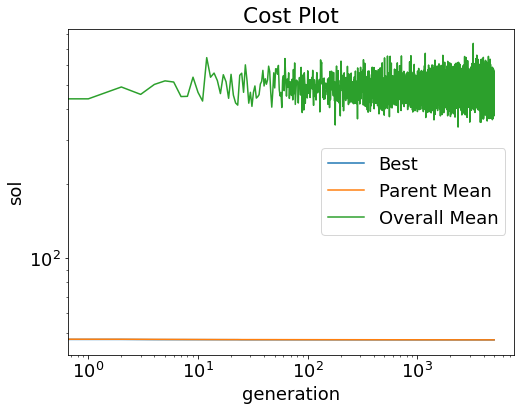

In [3]:
##initializing constants
k_1 = 80*10**9 # Pa                       <---           Phase 1 bulk modulus
mu_1 = 30*10**9 # Pa                      <---           Phase 1 shear modulus
sigma_1 = 1.0*10**7 # S/m                 <---           Phase 1 electrical conductivity
Kappa_1 = 4.3 # W/m-K                         <---           Phase 1 thermal conductivity
k_D = 111*10**9 # Pa                      <---           Desired Effective Bulk Modulus
mu_D = 47*10**9 # Pa                      <---           Desired Effective Shear Modulus
sigma_D = 2.1*10**7 # S/m                 <---           Desired Effective Electrical Conductivity
Kappa_D = 6.2 # W/m-K                         <---           Desired Effective Thermal Conductivity
TOL_k = 0.5 #                             <---           Bulk Modulus Tolerance
TOL_mu = 0.5 #                            <---           Shear Modulus Tolerance
TOL_sigma = 0.8 #                         <---           Electrical Tolerance
TOL_Kappa = 0.5 #                             <---           Thermal Tolerance
w = 0.8 #                                 <---           Concentration tensor weights
w_1 = 1 #                                 <---           Material property matching cost function weights


# Genetic Algorithm for Material Optimization
# Initializing genetic algorithm parameters
children = 10 #                           <---           number of children
parent = 10 #                             <---           number of parents
S = 200 #                                 <---           number of genes
G = 5000 #                                <---           total generation

W_1 = 1/3 #                               <---           cost function weight
W_2 = 1/3 #                               <---           cost function weight
W_3 = 1/3 #                               <---           cost function weight

# random number genration
rng = np.random.default_rng()

# generating k array of size S of values between 
k_2 = k_1*rng.random((S,1)) + 100*k_1

# generating mu array of size S of values between 
mu_2 = mu_1*rng.random((S,1)) + 100*mu_1

# generating sigma array of size S of values between 
sigma_2 = sigma_1*rng.random((S,1)) + 100*sigma_1

# generating K array of size S of values between 
Kappa_2 = Kappa_1*rng.random((S,1)) + 100*Kappa_1

# generating v array of size S of values between 
v_2 = rng.random((S,1))
v_1 = 1-v_2                         # ######### # <----  Double check this value

# organizing the tunable parameter generated for the genetic algorithm
Lambda = np.hstack([k_2, mu_2, sigma_2, Kappa_2, v_2])

#evaluating k_str, mu_str, sigma_str, K_str
k_strpls = k_2 + (1 - v_2)/(1/(k_1 - k_2) + 3*v_2/(3*k_2 + 4*mu_2))
k_strmns = k_1 + v_2/(1/(k_2 - k_1) + 3*(1 - v_2)/(3*k_1 + 4*mu_1))
k_str = (k_strpls + k_strmns)/2

mu_strpls = mu_2 + (1 - v_2)/(1/(mu_1 - mu_2) + 6*v_2*(k_2 + 2*mu_2)/(5*mu_2*(3*k_2 + 4*mu_2)))
mu_strmns = mu_1 + v_2/(1/(mu_2 - mu_1) + 6*(1-v_2)*(k_1 + 2*mu_1)/(5*mu_1*(3*k_1 + 4*mu_1)))
mu_str = (mu_strpls + mu_strmns)/2

sigma_strpls = sigma_2 + (1 - v_2)/(1/(sigma_1 - sigma_2) + v_2/(3*sigma_2))
sigma_strmns = sigma_1 + v_2/(1/(sigma_2 - sigma_1) + (1-v_2)/(3*sigma_1))
sigma_str = (sigma_strpls + sigma_strmns)/2

Kappa_strpls = Kappa_2 + (1 - v_2)/(1/(Kappa_1 - Kappa_2) + v_2/(3*Kappa_2))
Kappa_strmns = Kappa_1 + v_2/(1/(Kappa_2 - Kappa_1) + (1-v_2)/(3*Kappa_1))
Kappa_str = (Kappa_strpls + Kappa_strmns)/2

# evaluating C_sigma_k2, C_sigma_k1, C_sigma_mu2, C_sigma_mu1 for mechanical properties
C_sigma_k2 = k_2*(k_str-k_1)/(v_2*k_str*(k_2-k_1))
C_sigma_mu2 = mu_2*(mu_str-mu_1)/(v_2*mu_str*(mu_2-mu_1))

C_sigma_k1 = (1 - v_2*C_sigma_k2**2)/v_1
C_sigma_mu1 = (1 - v_2*C_sigma_mu2**2)/v_1


# evaluating C_j1C_e1 and C_j1C_e1 for electrical properties
C_j1C_e1 = sigma_1 * ((sigma_2 - sigma_str)/((1-v_2)*(sigma_2 - sigma_1)))**2 / sigma_str
C_j2C_e2 = sigma_2 * ((sigma_str - sigma_1)/(v_2*(sigma_2 - sigma_1)))**2 / sigma_str

# evaluating C_q1 and C_q2 for thermal properties
C_theta2 = (Kappa_str - Kappa_1)/(v_2*(Kappa_2 - Kappa_1)) 
C_theta1 = (1 - v_2*C_theta2)/(1 - v_2)
C_q2 = Kappa_2*C_theta2/Kappa_str
C_q1 = (1 - v_2*C_q2)/(1 - v_2)

# running the numerical simulation for the mechical properties
pi_mechanical = np.array([w_1*((k_D-k_str[i])/k_D)**2 + w_1*((mu_D-mu_str[i])/mu_D)**2 + int(C_sigma_k2[i] > TOL_k)*w*((C_sigma_k2[i] - TOL_k)/TOL_k)**2 + int(C_sigma_mu2[i] > TOL_mu)*w*((C_sigma_mu2[i] - TOL_mu)/TOL_mu)**2 + int(C_sigma_k1[i] > TOL_k)*w*((C_sigma_k1[i] - TOL_k)/TOL_k)**2 + int(C_sigma_mu1[i] > TOL_mu)*w*((C_sigma_mu1[i] - TOL_mu)/TOL_mu)**2 for i in range(S)])

# running the numerical simulation for the electrical properties
pi_electrical = np.array([w_1*((sigma_D-sigma_str[i])/sigma_D)**2 + int(C_j1C_e1[i] > TOL_sigma)*w*((C_j1C_e1[i] - TOL_sigma)/TOL_sigma)**2 + int(C_j2C_e2[i] > TOL_sigma)*w*((C_j2C_e2[i] - TOL_sigma)/TOL_sigma)**2 for i in range(S)])

# running the numerical simulation for the thermal properties
pi_thermal = np.array([w_1*((Kappa_D - Kappa_str[i])/Kappa_D)**2 + int(C_q1[i] > TOL_sigma)*w*((C_q1[i] - TOL_sigma)/TOL_sigma)**2 + int(C_q2[i] > TOL_sigma)*w*((C_q1[i] - TOL_sigma)/TOL_sigma)**2 for i in range(S)])

# sim_res = [trnsTempSim(21, Lambda[i,0],Lambda[i,1]) for i in range(S)]

# evaluating the cost of each member of the population
new_pi = W_1*pi_mechanical + W_2*pi_electrical + W_3*pi_thermal

# initializing the generation count
g = 1

# labeling the data
dtype = [('Lambda1', float), ('Lambda2', float), ('Lambda3', float), ('Lambda4', float), ('Lambda5', float), ('new_pi', float)]

# Organzing the data for each member of the population
Pi=[]
for _ in range(S):
    Pi.append((Lambda[_][0], Lambda[_][1], Lambda[_][2], Lambda[_][3], Lambda[_][4], float(new_pi[_])))

# converting to an array and sorting the list of the population over the new pi
Pi1 = np.array(Pi, dtype=dtype)
Sorted_Pi = np.sort(Pi1, order='new_pi')

g = 1

# initializing variable tracking the GA performance
Parent_avg = []
PI_avg = []
PI_min = []
Sol1 = []
Sol2 = []

PI_min.append(Sorted_Pi['new_pi'][0])
Parent_avg.append(Sorted_Pi['new_pi'][0:10].mean())
PI_avg.append(Sorted_Pi['new_pi'].mean())
Sol1.append(Sorted_Pi['Lambda1'][0])
Sol2.append(Sorted_Pi['Lambda2'][0])
print('---------------------generation', g, '---------------------')
# print('K_o: ', Sol1[-1], '\nfl: ', Sol2[-1])
print('PI_min: ', PI_min[-1])
#==========================================================================================================================
# genetic algorithm iteration
while g<G:
    g+=1
    for p in 2*np.arange(0,5):
        phi1 = rng.random()
        phi2 = rng.random()
        phi3 = rng.random()
        phi4 = rng.random()
        phi5 = rng.random()
        phi1a = rng.random()
        phi2a = rng.random()
        phi3a = rng.random()
        phi4a = rng.random()
        phi5a = rng.random()
        
        ## mating parents to produce children that replaces worse parents
        Sorted_Pi['Lambda1'][p], Sorted_Pi['Lambda1'][p+1] =  phi1*Sorted_Pi['Lambda1'][p] + (1-phi1)*Sorted_Pi['Lambda1'][p+1], phi1a*Sorted_Pi['Lambda1'][p] + (1-phi1a)*Sorted_Pi['Lambda1'][p+1]
        Sorted_Pi['Lambda2'][p], Sorted_Pi['Lambda2'][p+1] =  phi2*Sorted_Pi['Lambda2'][p] + (1-phi2)*Sorted_Pi['Lambda2'][p+1], phi2a*Sorted_Pi['Lambda2'][p] + (1-phi2a)*Sorted_Pi['Lambda2'][p+1]
        Sorted_Pi['Lambda3'][p], Sorted_Pi['Lambda3'][p+1] =  phi3*Sorted_Pi['Lambda3'][p] + (1-phi3)*Sorted_Pi['Lambda3'][p+1], phi3a*Sorted_Pi['Lambda3'][p] + (1-phi3a)*Sorted_Pi['Lambda3'][p+1]
        Sorted_Pi['Lambda4'][p], Sorted_Pi['Lambda4'][p+1] =  phi4*Sorted_Pi['Lambda4'][p] + (1-phi4)*Sorted_Pi['Lambda4'][p+1], phi4a*Sorted_Pi['Lambda4'][p] + (1-phi4a)*Sorted_Pi['Lambda4'][p+1]
        Sorted_Pi['Lambda5'][p], Sorted_Pi['Lambda5'][p+1] =  phi5*Sorted_Pi['Lambda5'][p] + (1-phi5)*Sorted_Pi['Lambda5'][p+1], phi5a*Sorted_Pi['Lambda5'][p] + (1-phi5a)*Sorted_Pi['Lambda5'][p+1]

        ##evaluating new pi
        Sorted_Pi['new_pi'][p] =  PI_function(Sorted_Pi['Lambda1'][p], Sorted_Pi['Lambda2'][p], Sorted_Pi['Lambda3'][p], Sorted_Pi['Lambda4'][p], Sorted_Pi['Lambda5'][p])
        Sorted_Pi['new_pi'][p+1] =  PI_function(Sorted_Pi['Lambda1'][p+1], Sorted_Pi['Lambda2'][p+1], Sorted_Pi['Lambda3'][p+1], Sorted_Pi['Lambda4'][p+1], Sorted_Pi['Lambda5'][p+1])
        
        
        
    ## generating new random values
    for N in range(10,S):
        Sorted_Pi['Lambda1'][N] =  k_1*rng.random() + 100*k_1
        Sorted_Pi['Lambda2'][N] =  mu_1*rng.random() + 100*mu_1
        Sorted_Pi['Lambda3'][N] =  sigma_1*rng.random() + 100*sigma_1
        Sorted_Pi['Lambda4'][N] =  Kappa_1*rng.random() + 100*Kappa_1
        Sorted_Pi['Lambda5'][N] =  rng.random()
        
        ##evaluating new pi
        Sorted_Pi['new_pi'][N] =  PI_function(Sorted_Pi['Lambda1'][N], Sorted_Pi['Lambda2'][N], Sorted_Pi['Lambda3'][N], Sorted_Pi['Lambda4'][N], Sorted_Pi['Lambda5'][N])
        
    ## sorting and appending values    
    Sorted_Pi = np.sort(Sorted_Pi, order='new_pi')
    PI_min.append(Sorted_Pi['new_pi'][0])
    Parent_avg.append(Sorted_Pi['new_pi'][0:10].mean())
    PI_avg.append(Sorted_Pi['new_pi'].mean())
    Sol1.append(Sorted_Pi['Lambda1'][0])
    Sol2.append(Sorted_Pi['Lambda2'][0])
    # print('---------------------generation', g, '---------------------')
    # # print('K_o: ', Sol1[-1], '\nfl: ', Sol2[-1])
    # print('PI_min: ', PI_min[-1])
    # print('Parent_avg: ', Parent_avg[-1])

# Plotting solution
fig = plt.figure(figsize = (8,6))
plt.rcParams.update({'font.size': 18})
plt.plot(PI_min, label = 'Best')
plt.plot(Parent_avg, label = 'Parent Mean')
plt.plot(PI_avg, label = 'Overall Mean')
# plt.plot(Sol1, label = '$\lambda1$')
# plt.plot(Sol2, label = '$\lambda2$')
# naming the x axis
plt.xlabel('generation')
# naming the y axis
plt.ylabel('sol')
# giving a title to my graph
plt.title('Cost Plot')
plt.loglog()
plt.legend()
print('PI_min: ', PI_min[-1])
# plt.savefig('Proj_2_figure_'+str(iter))
plt.show()